<a href="https://colab.research.google.com/github/AlexanderCoudijzer/Fashion-MNIST_using_NN/blob/main/Fashion_MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of the Fashion MNIST dataset.
This is an example of using a neural network for images to classify without CNN. 

## 1. Data Loading

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
import sys
sys.path.append('.')
from IPython import display
from matplotlib import pyplot as plt

In [2]:
def load_data_fashion_mnist(batch_size, num_workers, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=num_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=num_workers))

In [3]:
# Read training and test data
batch_size = 256
num_workers = 2
train_iter, test_iter = load_data_fashion_mnist(batch_size, num_workers)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



## 2. Net Definiton

In [4]:
class Net_test3c(torch.nn.Module):
    def __init__(self, patch_size, dim_d, num_hidden1, num_hidden2, num_outputs):
        """Defining the model"""
        super(Net_test3c, self).__init__()
        self.patch_size = patch_size
        self.dim_num = int(28/patch_size)**2
        self.dim_d = dim_d
        self.num_hidden1 = num_hidden1
        self.num_hidden2 = num_hidden2
        self.num_outputs = num_outputs
        self.Linear_ST = nn.Linear(patch_size**2, dim_d) # Linear layer forming the stem
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.2)
        self.Linear_BL1 = nn.Linear(self.dim_num, self.num_hidden1) # Backbone block part 1
        self.Linear_BL2 = nn.Linear(self.num_hidden1, self.dim_num) # Backbone block part 1
        self.Linear_BL3 = nn.Linear(self.dim_d, self.num_hidden2) # Backbone block part 2
        self.Linear_BL4 = nn.Linear(self.num_hidden2, self.dim_d) # Backbone block part 2
        self.Linear_CL = nn.Linear(self.dim_d,self.num_outputs) # Classifier
        
    def forward(self, x):
        unfold = torch.nn.Unfold((self.patch_size), dilation=1, padding=0, stride=self.patch_size)
        x = self.Linear_ST(unfold(x).transpose(1,2)) #STEM
        x = self.Linear_BL2(self.drop(self.relu(self.Linear_BL1(x.transpose(1,2))))) #BLOCK_part1
        x = self.Linear_BL4(self.drop(self.relu(self.Linear_BL3(x.transpose(1,2))))) #BLOCK_part2
        mean_ft = torch.nn.AdaptiveAvgPool2d((1,self.dim_d))  
        out = self.Linear_CL(mean_ft(x).reshape(-1,dim_d)) # Averaging features and feeding them to classifer
        return out

In [5]:
def init_weights_He_norm(m):
    if type(m) == nn.Linear: # by checking type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias) #.zeros

## 3. Training and Evaulation Functions

In [6]:
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)        
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y),
                       y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.6, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print('train_loss: ',train_loss,'train_acc: ', train_acc, 'test_acc: ', test_acc)

## 4. Training


train_loss:  0.28241365813414254 train_acc:  0.89785 test_acc:  0.8613


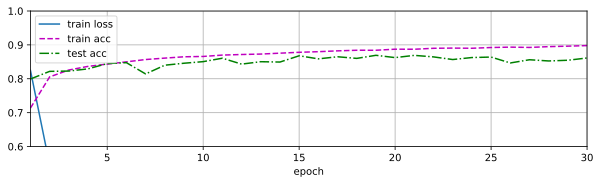

In [7]:
patch_size, dim_d, num_hidden1, num_hidden2, num_outputs = 14, 200, 12, 100, 10
lr, wd = 0.1, 0.002
num_epochs = 30

net = Net_test3c(patch_size, dim_d, num_hidden1, num_hidden2, num_outputs)
net.apply(init_weights_He_norm)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

## 5. Example classification

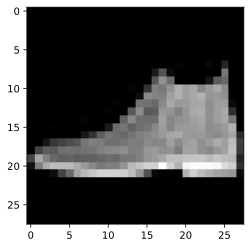

The predicted label is: Ankle Boot
The true label is: Ankle Boot


In [82]:
label_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

item_to_test = 0 # between 0 and 255 (batch size)

input, label = next(iter(test_iter)) # only taking examples from the first batch
fig = plt.figure
plt.imshow(input[item_to_test][0], cmap='gray')
plt.show()
output_label = int(torch.argmax(net(input)[item_to_test]))
print('The predicted label is:',label_dict[output_label])
print('The true label is:',label_dict[int(label[item_to_test])])

## References
The loading and training functions were adapted based on code from:  
Zhang, A., Lipton, Z C., Li, M. and Smola, A J. (2021) ‘Dive into Deep Learning’, arXiv preprint arXiv:2106. 11342.  
http://d2l.ai/